In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import telegraph as tg

In [3]:
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
PATHS = dict(sc = '../data/common/10x_bc_xsv/sc/curated/og_adata.h5ad',
             visium = '../data/common/10x_bc_xsv/visium/curated/og_adata.h5ad',
            )

In [5]:
ad_sc = ad.read_h5ad(PATHS['sc'])
ad_vs = ad.read_h5ad(PATHS['visium'])


In [6]:
ad_vs.obsm['spatial'] = ad_vs.obsm['spatial'].astype(float)

## QC

Single cell data

In [7]:
print('before:')
print('shape : {}x{}'.format(*ad_sc.shape))
ad_sc.var_names_make_unique()
sc.pp.filter_genes(ad_sc, min_cells= 10)
sc.pp.filter_genes(ad_sc, min_counts= 20)
sc.pp.filter_cells(ad_sc, min_counts = 100)
sc.pp.filter_cells(ad_sc, min_genes = 1000)
print('after:')
print('shape : {}x{}'.format(*ad_sc.shape))

before:
shape : 9386x18082
after:
shape : 7469x14880


Visium data

In [8]:
print('before:')
print('shape : {}x{}'.format(*ad_vs.shape))
sc.pp.filter_genes(ad_vs, min_cells= 0.01)
sc.pp.filter_genes(ad_vs, min_counts= 300)
sc.pp.filter_cells(ad_vs,min_genes=2000)
ad_vs.var_names_make_unique()
print('after:')
print('shape : {}x{}'.format(*ad_vs.shape))

before:
shape : 4169x18085
after:
shape : 4028x11650


Inspect the Visium data to make sure it makes sense

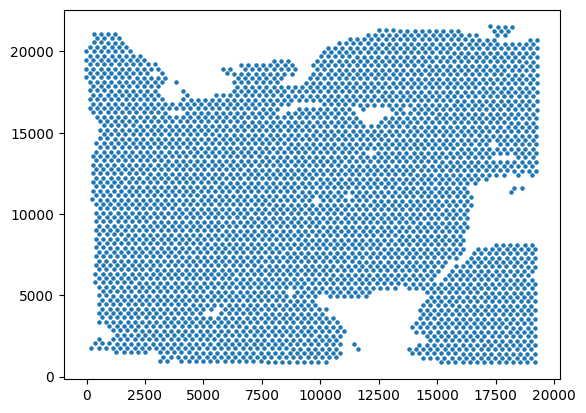

In [9]:
plt.scatter(ad_vs.obsm['spatial'][:,0], ad_vs.obsm['spatial'][:,1], s = 5)
plt.show()

## Visium + SC analysis

Get HVG genes from the single cell data and clusters from scRNA-seq data, this can be replaced with known marker genes or cell type labels (this is just for the demo). We will treat clusters as cell types (even though we haven't annotated them)

In [10]:
ad_sc.layers['raw'] = ad_sc.X.copy()
sc.pp.normalize_total(ad_sc)
sc.pp.log1p(ad_sc)
ad_sc.layers['norm'] = ad_sc.X.copy()
sc.pp.highly_variable_genes(ad_sc,n_top_genes=2000)
sc.pp.pca(ad_sc)
sc.pp.neighbors(ad_sc)
sc.tl.louvain(ad_sc, resolution = 1)
ad_sc.obs['louvain'] = [f'cluster_{x}' for x in ad_sc.obs['louvain'].values]
ad_sc.X = ad_sc.layers['raw'].copy()
hvg_names = ad_sc.var_names[ad_sc.var['highly_variable'].values].tolist()

In [11]:
sc.tl.umap(ad_sc)

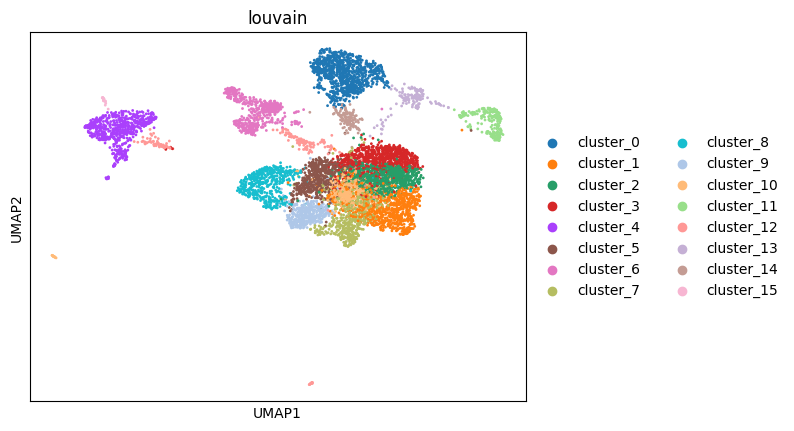

In [12]:
sc.pl.umap(ad_sc,color = 'louvain')

Get the ligand receptor interactions that are present in the data

In [13]:
cpdb_res = tg.ext.cpdb.run(ad_sc,
                          label_col = 'louvain',
                          cpdb_file_path='../rsc/cellphonedb/cellphonedb.zip',
                           )
                

[ ][CORE][25/07/24-09:07:34][INFO] [Non Statistical Method] Threshold:0.1 Precision:3
Reading user files...
The following user files were loaded successfully:
counts from AnnData object
/tmp/tmp8sygah74/meta.csv
[ ][CORE][25/07/24-09:07:36][INFO] Running Basic Analysis
[ ][CORE][25/07/24-09:07:36][INFO] Building results
Saved means_result to /tmp/tmp8sygah74/simple_analysis_means_result_07_25_2024_090736.txt
Saved deconvoluted to /tmp/tmp8sygah74/simple_analysis_deconvoluted_07_25_2024_090736.txt
Saved deconvoluted_percents to /tmp/tmp8sygah74/simple_analysis_deconvoluted_percents_07_25_2024_090736.txt
Saved significant_means_result to /tmp/tmp8sygah74/simple_analysis_significant_means_result_07_25_2024_090736.txt


Get top 20 ligand and target interactions

In [14]:
ligand_target_list = [(x.ligand,x.target) for x in cpdb_res.head(20).itertuples()]

### Telegraph workflow

Next step is to create `input_dict` the main object of `telegraph` - this is the object that hold your data througout the whole workflow. It's a dictionary with the following entries:
- `X_to` : expression of reference data (usually your spatial data)
- `X_from` : expression data to be transferred (usually your sc data). Will also hold groups after the grouping step (e.g., interacting and non-interacting)
- `D_{to,from}` : Design Matrices indicating categorical and continous covariates
- `T` : map that relates objects in `to` to objects in `from`
- `X_{to,from}_pred` : corrected or imputed gene expression
- `DEA` : DEA results
- `S_{to,from}` - spatial coordinates for data 

You can enter the workflow at any entrypoint, but the minimal requirment is to have `X_from` and `X_to`, from this the other objects can be generated by the workflow.

There's a helper function that allows you to 

In [15]:
input_dict_scvs = tg.met.utils.adatas_to_input({'from':ad_sc.copy(), 'to':ad_vs.copy()}, # provide the data to be used
                                                categorical_labels={'from':['louvain']}, # include cluster labels in the design matrix
                                              )

Inspect the `input_dict` object

In [16]:
input_dict_scvs

{'X_from': AnnData object with n_obs × n_vars = 7469 × 14880
     obs: 'n_counts', 'n_genes', 'louvain'
     var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'log1p', 'hvg', 'pca', 'neighbors', 'louvain', 'umap', 'louvain_colors'
     obsm: 'X_pca', 'X_umap'
     varm: 'PCs'
     layers: 'raw', 'norm'
     obsp: 'distances', 'connectivities',
 'D_from':                             cluster_0  cluster_1  cluster_2  cluster_3  \
 AAACAAGCAGAAAGGTAGTAGGCT-1        0.0        0.0        0.0        1.0   
 AAACCAATCAATGTGAAGTAGGCT-1        0.0        0.0        1.0        0.0   
 AAACCAATCCTAAGGGAGTAGGCT-1        0.0        0.0        0.0        0.0   
 AAACCAATCGGTACAGAGTAGGCT-1        0.0        0.0        0.0        1.0   
 AAACCAGGTAATCCTAAGTAGGCT-1        0.0        0.0        0.0        0.0   
 ...                               ...        ...        ...        ...   
 TTTGGCGGTCACTATAAGTAGGCT-1   

These are the current objects in the `input_dict`

In [17]:
keys = ','.join(list([x for x in input_dict_scvs.keys()]))
print(f'Current objects in input_dict : {keys}')

Current objects in input_dict : X_from,D_from,X_to,S_to


We will use the `methods` module to do our subsequent operations, all these functions can be called with `tg.met.{method_type}.run`.
The `{method_type}` indicates the type of method to use. You can see the implemented methods by calling `tg.constants.METHODS.OPTIONS.value`

In [23]:
tg.constants.METHODS.OPTIONS.value

{'map_random': telegraph.methods.map_methods.RandomMap,
 'map_max_corr': telegraph.methods.map_methods.ArgMaxCorrMap,
 'map_tangram_v1': telegraph.methods.map_methods.TangramV1Map,
 'map_tangram_v2': telegraph.methods.map_methods.TangramV2Map,
 'map_celery': telegraph.methods.map_methods.CeLEryMap,
 'map_spaotsc': telegraph.methods.map_methods.SpaOTscMap,
 'map_moscot': telegraph.methods.map_methods.MoscotMap,
 'prd_tangram_v1': telegraph.methods.pred_methods.TangramV1Pred,
 'prd_tangram_v2': telegraph.methods.pred_methods.TangramV2Pred,
 'prd_moscot': telegraph.methods.pred_methods.MoscotPred,
 'imp_mean': telegraph.methods.imp_methods.MeanImputation,
 'imp_knn': telegraph.methods.imp_methods.KNNImputation,
 'imp_fcnn': telegraph.methods.imp_methods.FCNNImputation,
 'imp_vaeknn': telegraph.methods.imp_methods.VAEKNNImputation,
 'imp_gimvi': telegraph.methods.imp_methods.gimVIImputation,
 'imp_spage': telegraph.methods.imp_methods.SpaGEImputation,
 'grp_threshold': telegraph.methods.gr

We will exectute the following workflow: `MAP -> PREDICT -> GROP -> DEA`. For Xenium/MERFISH/CosMx data it would be more appropriate to do  `IMPUTE -> GROUP -> DEA`

### Preprocess data
We use our pre-processing module for this

In [18]:
tg.met.pp.StandardTangramV1.run(input_dict_scvs)

## Map cells to space

We will use `Tangram1` to map the cells to space, but any mapping method would work equally well

In [19]:
map_res = tg.met.map_methods.TangramV1Map.run(input_dict_scvs,
                                              num_epochs = 1000,
                                              genes =hvg_names,
                                             )

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 1514 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.483, KL reg: 0.000
Score: 0.721, KL reg: 0.000
Score: 0.730, KL reg: 0.000
Score: 0.732, KL reg: 0.000
Score: 0.733, KL reg: 0.000
Score: 0.733, KL reg: 0.000
Score: 0.734, KL reg: 0.000
Score: 0.734, KL reg: 0.000
Score: 0.734, KL reg: 0.000
Score: 0.734, KL reg: 0.000


INFO:root:Saving results..


The output is a new dictionary that holds the `T` object (described above)

In [20]:
map_res['T'].iloc[0:10,0:10]

,AAACAAGCAGAAAGGTAGTAGGCT-1,AAACCAATCAATGTGAAGTAGGCT-1,AAACCAATCCTAAGGGAGTAGGCT-1,AAACCAATCGGTACAGAGTAGGCT-1,AAACCAGGTAATCCTAAGTAGGCT-1,AAACCAGGTCGCAACCAGTAGGCT-1,AAACCAGGTGAACGTAAGTAGGCT-1,AAACCAGGTTAACGGAAGTAGGCT-1,AAACCAGGTTAGTAGGAGTAGGCT-1,AAACCAGGTTAGTGAGAGTAGGCT-1
AACACTTGGCAAGGAA-1,0.0,0.000001,0.0,0.0,0.0,0.000001,0.0,0.0,0.000001,0.0
AACAGGATTCATAGTT-1,0.000001,0.000001,0.0,0.000001,0.0,0.0,0.0,0.000023,0.000001,0.0
AACAGGCCAACGATTA-1,0.0,0.000001,0.0,0.0,0.000001,0.0,0.0,0.0,0.0,0.000001
AACAGGTTATTGCACC-1,0.000009,0.0,0.0,0.000001,0.000001,0.0,0.000001,0.000001,0.000001,0.000001
AACAGGTTCACCGAAG-1,0.000001,0.0,0.000001,0.000004,0.000001,0.000001,0.0,0.0,0.0,0.0
AACAGTCAGGCTCCGC-1,0.0,0.0,0.0,0.0,0.0,0.000011,0.000001,0.000001,0.0,0.000001
AACAGTCCACGCGGTG-1,0.000001,0.0,0.0,0.0,0.0,0.0,0.000001,0.0,0.000001,0.000003
AACATACTCATATGCG-1,0.000001,0.000002,0.000135,0.0,0.0,0.0,0.000001,0.0,0.000001,0.0
AACATAGTCTATCTAC-1,0.0,0.000001,0.0,0.0,0.000001,0.0,0.000002,0.000002,0.0,0.000001
AACATCTAATGACCGG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.000001,0.0,0.0,0.0


The `T` matrix has the dimensions `[n_to] x [n_from]`

In [21]:
print(f'n_spots : {ad_vs.shape[0]} | n_cells : {ad_sc.shape[0]} | T dims : {map_res["T"].shape[0]}x{map_res["T"].shape[1]}')

n_spots : 4028 | n_cells : 7469 | T dims : 4028x7469


Update the `input_dict` with the mapping results

In [22]:
input_dict_scvs.update(map_res)

We can inspect how the "cell types" are mapped to space

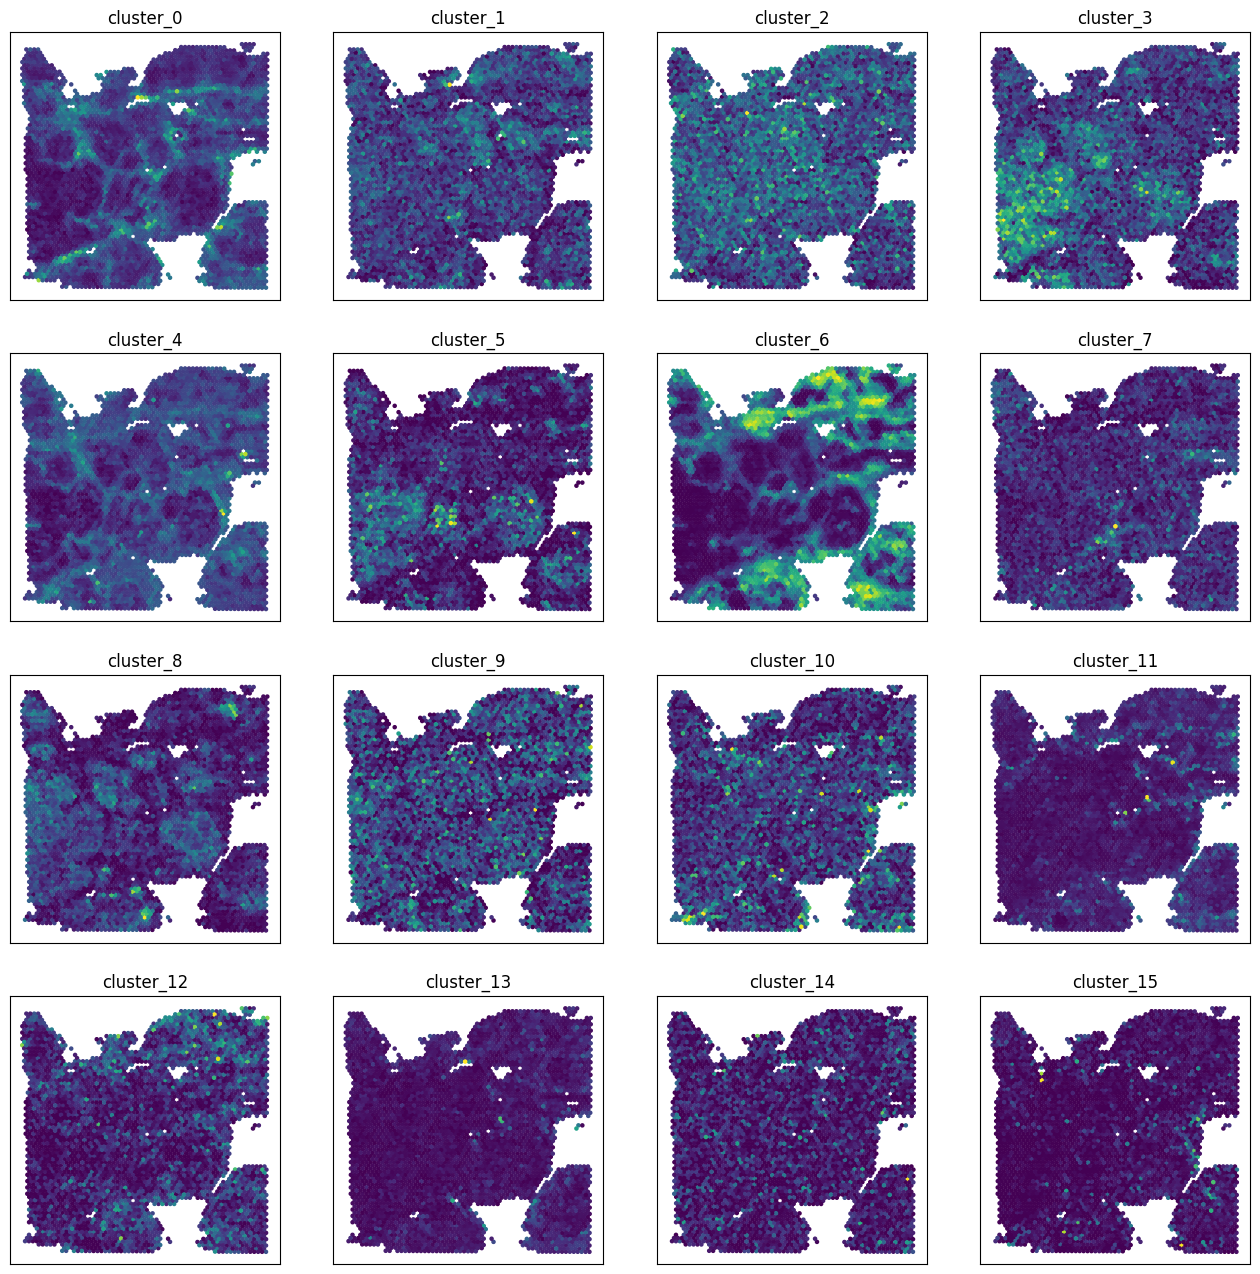

In [29]:
tg.dig.map.plot_from_feature_on_to(input_dict_scvs, features=input_dict_scvs['D_from'],marker_size=5)

We could also look at some stats for the map, to see whether the mapping seems successful

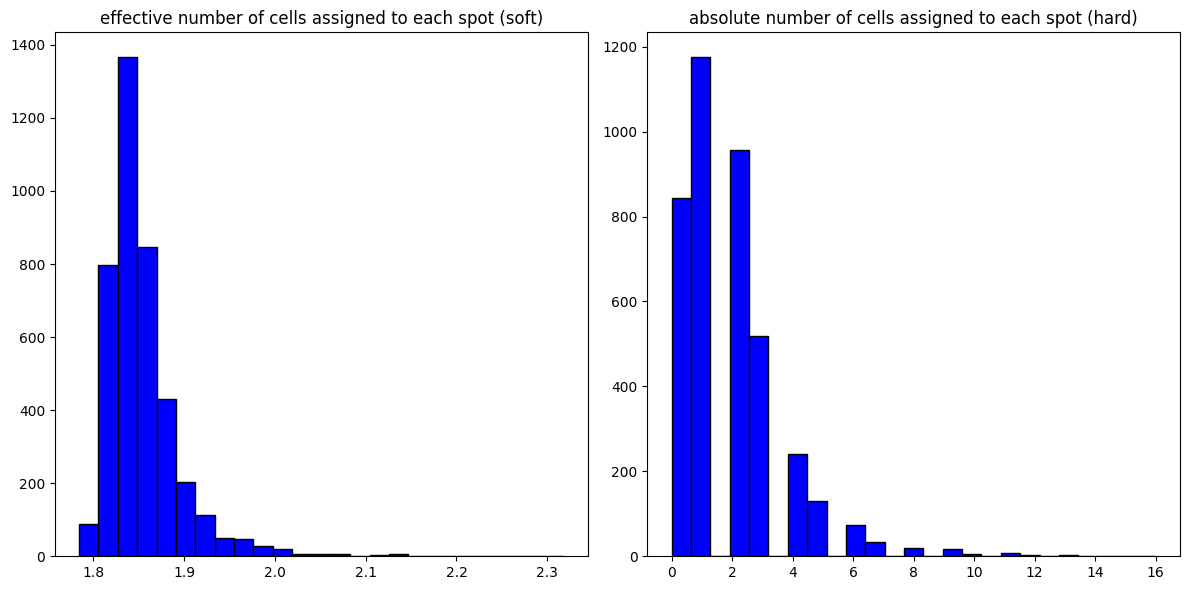

In [30]:
tg.dig.map.plot_cells_per_spot(input_dict_scvs['T'])

Let's also look at how the mapping values are distributed, element `T_ij` indicates how likely cell `j` is to be mapped to spot `i`. We can look at the top 1 (the spot it's most likely to be assigned to) value for each cell and compare it with other top k values. If the assignement is confident there should be a separation between the distributions.

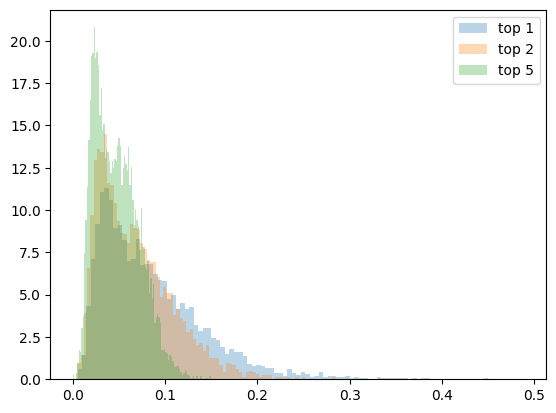

In [324]:
tg.dig.map.plot_top_k_distribution(map_res['T'], ks= [1,2,5,])

### Predict

We now correct the noisy gene expression in the spatial data by leveraging the sc data

In [31]:
prd_out = tg.methods.pred_methods.TangramV1Pred.run(input_dict_scvs,)

Update the `input_dict with the result

In [33]:
input_dict_scvs.update(prd_out)

We can compare some of the predicted gene expression of the ligands compared with the observed gene expression

In [48]:
ligands,targets = list(zip(*ligand_target_list))
plot_ligands = list(set(ligands))

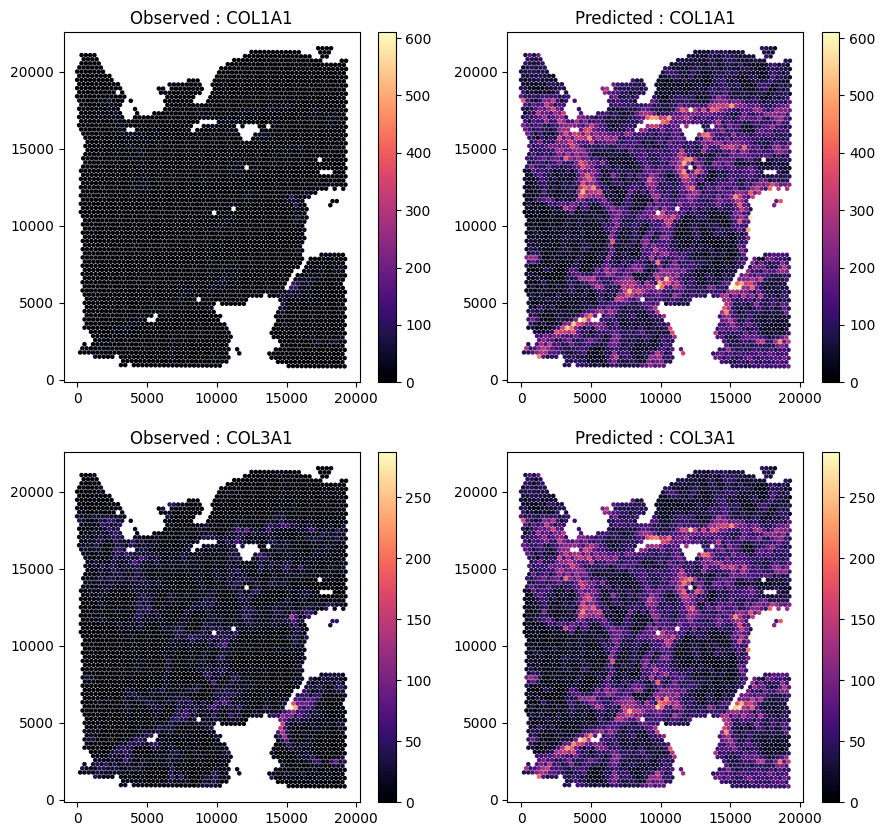

In [41]:
tg.dig.pred.plot_pred_vs_obs(input_dict_scvs, feature_names=plot_ligands,marker_size = 5)

### Group

Next we'll group the cells into interacting and non-interacting, for historical reasons we use adj for interacting and nadj for non-interacting

We use a method called Quantile Grouping here, this essentially separates cells in the scRNA-seq data w.r.t. how strongly associated they are with the gene expression of the ligands in the spatial data.

In [42]:
grp_out = tg.methods.grp_methods.QuantileGroup.run(input_dict_scvs,
                                                   feature_name = ligand_target_list,
                                                  )

In [44]:
grp_out['D_from']

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,...,nadj_COL3A1_cluster_13,adj_COL3A1_cluster_13,nadj_COL3A1_cluster_15,adj_COL3A1_cluster_15,nadj_COL3A1_cluster_0,adj_COL3A1_cluster_0,nadj_COL3A1_cluster_11,adj_COL3A1_cluster_11,nadj_COL3A1_cluster_14,adj_COL3A1_cluster_14
AAACAAGCAGAAAGGTAGTAGGCT-1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
AAACCAATCAATGTGAAGTAGGCT-1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
AAACCAATCCTAAGGGAGTAGGCT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
AAACCAATCGGTACAGAGTAGGCT-1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
AAACCAGGTAATCCTAAGTAGGCT-1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGCGGTCACTATAAGTAGGCT-1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
TTTGGCGGTCTCACTCAGTAGGCT-1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
TTTGGCGGTGGTGAGTAGTAGGCT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
TTTGTGAGTAGCCCGTAGTAGGCT-1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


Update the input dict

In [62]:
input_dict_scvs.update(grp_out)

Get the different groups in the data (combination of ligands and target cell types here)

In [54]:
groups = [[f'adj_{l}_{t}',f'nadj_{l}_{t}'] for l,t in zip(ligands,targets)]
groups

[['adj_COL1A1_cluster_13', 'nadj_COL1A1_cluster_13'],
 ['adj_COL1A1_cluster_15', 'nadj_COL1A1_cluster_15'],
 ['adj_COL1A1_cluster_0', 'nadj_COL1A1_cluster_0'],
 ['adj_COL1A1_cluster_11', 'nadj_COL1A1_cluster_11'],
 ['adj_COL1A1_cluster_14', 'nadj_COL1A1_cluster_14'],
 ['adj_COL1A1_cluster_8', 'nadj_COL1A1_cluster_8'],
 ['adj_COL1A1_cluster_3', 'nadj_COL1A1_cluster_3'],
 ['adj_COL1A1_cluster_10', 'nadj_COL1A1_cluster_10'],
 ['adj_COL1A1_cluster_6', 'nadj_COL1A1_cluster_6'],
 ['adj_COL1A1_cluster_9', 'nadj_COL1A1_cluster_9'],
 ['adj_COL1A1_cluster_1', 'nadj_COL1A1_cluster_1'],
 ['adj_COL1A1_cluster_2', 'nadj_COL1A1_cluster_2'],
 ['adj_COL1A1_cluster_7', 'nadj_COL1A1_cluster_7'],
 ['adj_COL1A1_cluster_5', 'nadj_COL1A1_cluster_5'],
 ['adj_COL1A1_cluster_12', 'nadj_COL1A1_cluster_12'],
 ['adj_COL3A1_cluster_13', 'nadj_COL3A1_cluster_13'],
 ['adj_COL3A1_cluster_15', 'nadj_COL3A1_cluster_15'],
 ['adj_COL3A1_cluster_0', 'nadj_COL3A1_cluster_0'],
 ['adj_COL3A1_cluster_11', 'nadj_COL3A1_cluster_

Let's inspect the quality of out groups, we don't have ground truth but we can look at a few simple metrics

First we calculate the silhouette score between adj/nadj cells

In [97]:
sh_score = tg.dig.group.get_group_silhouette_score(input_dict_scvs,groups=groups,target = 'from')

We caj plot these for easier inspection

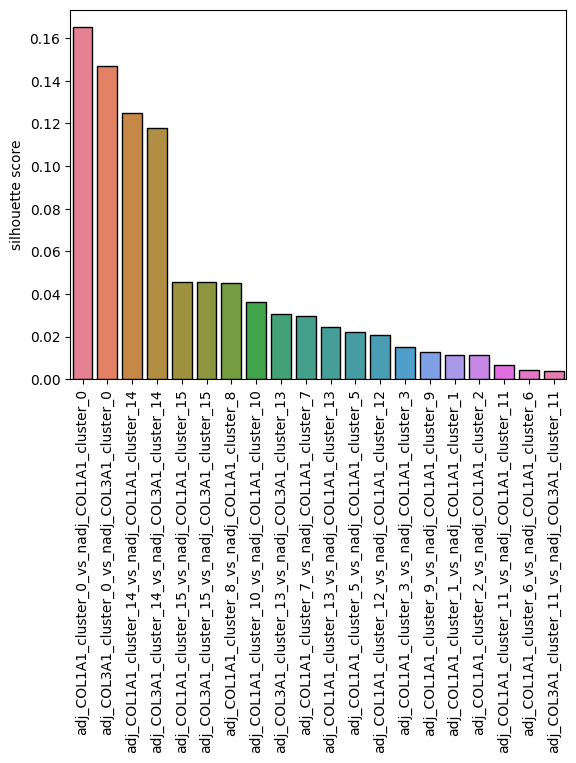

In [99]:
tg.dig.group.plot_group_silhouette_score(sh_score)

### DEA

Next step is to do a DEA analysis between adj/nadj (interacting non-interacting) cells. This should, in theory, give us the downstream genes impacted by the interaction

In [100]:
dea_out = tg.methods.dea_methods.ScanpyDEA.run(input_dict_scvs,
                                               groups= groups, 
                                               target = 'from',
                                               mode='pos',
                                               pval_cutoff = 0.01,
                                              )

The output is again a dictionary, we can look at one specific interaction to assess the results, let's take one with good separability

In [105]:
single_dea = dea_out['DEA']['from_adj_COL1A1_cluster_0_vs_nadj_COL1A1_cluster_0']
single_dea

,names,scores,logfoldchanges,pvals,pvals_adj
0,col1a1,10.422614,488.487244,1.955051e-25,2.909115e-21
1,col1a2,10.245543,161.539032,1.239281e-24,9.220252e-21
2,col3a1,8.949466,195.835571,3.572067e-19,1.382934e-15
3,sparc,8.945058,35.296288,3.717565e-19,1.382934e-15
4,sfrp2,8.364247,26.729650,6.049970e-17,1.800471e-13
...,...,...,...,...,...
60,col6a1,4.132529,11.972101,3.587933e-05,5.036646e-03
61,timp1,4.106446,2.788075,4.017935e-05,5.587558e-03
62,txndc5,4.077056,1.022644,4.560943e-05,6.194935e-03
63,lox,4.075954,1.021429,4.582601e-05,6.194935e-03


Let's see what pathways these correspond to 

In [107]:
pathway_enr_res = tg.diagnostics.dea.interpret_dea_features(single_dea, sources = ['GO:BP'])

Inspect the different pathways that are enriched in each analysis

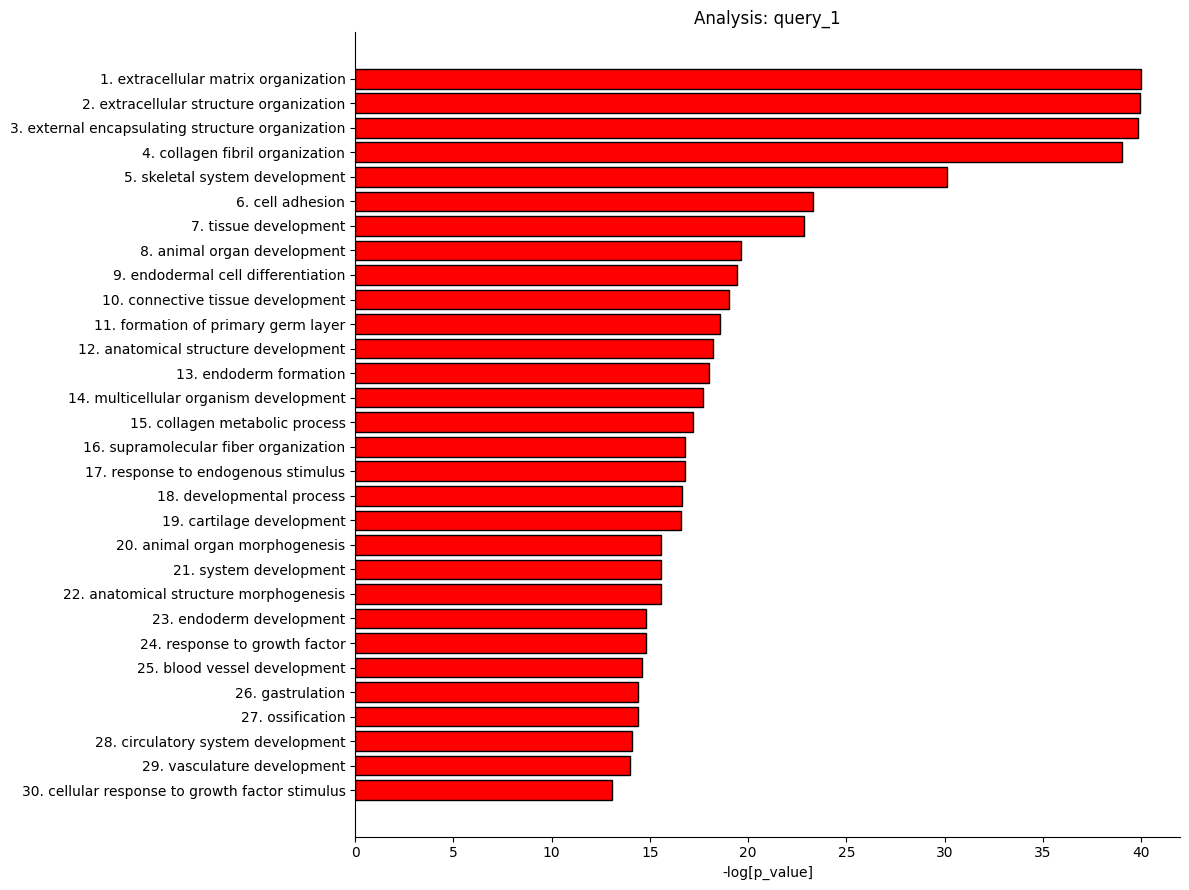

In [109]:
tg.diagnostics.dea.plot_top_k_enrichment_results(pathway_enr_res,
                                                 top_k = 30)

## Creating Workflows

If you don't want to exectute every step manually, and update the input dict, you can also create WorkFlows, this does it for you automatically. The analysis we did above could be compiled as follows:

In [115]:
from telegraph.methods.workflows import Workflow
wf_setup = {'pp' : {'method': tg.met.pp.StandardTangramV1},
            'map':{'method': tg.met.map.TangramV1Map,
                  'params' : {'num_epochs':1000, 'genes': hvg_names}},
           'pred': {'method':tg.met.pred_methods.TangramV1Pred},
           'group':{'method':tg.met.grp.QuantileGroup,
                     'params':{'feature_name':ligand_target_list}},
            'dea' :{'method':tg.met.dea.ScanpyDEA,
                   'params': {'groups':groups,'target':'from','mode':'pos'}},
        }

wf = Workflow(wf_setup)

wf.run(input_dict_scvs)